<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/Graph_Retail_Descriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone -b retail_data_branch --single-branch https://github.com/arangodb/interactive_tutorials.git
!rsync -av  interactive_tutorials/notebooks/data  rsync -av interactive_tutorials/notebooks/tools interactive_tutorials/notebooks/img ./ --exclude=.git
!pip install python-arango
!pip install arangopipe==0.0.6.9.5
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip3 install networkx
!pip3 install matplotlib
!pip3 install adbnx-adapter
!chmod a+x tools/* 

# Overview
In the previous notebook, characteristic features of the frequent shopper group were identified using ideas used to characterize bi-partitite graphs, and, networks in general. In particular, we are able to identify the customer and the item projection graphs as _small world networks_. _Small world networks_ have higher clustering coefficients than _Erdos Renyi_ random graphs. In _small world networks_ , (Watts-Strogatz) most nodes have similar degrees. A small set of nodes have high degrees. A small set of nodes have low degrees. Such a distribution of degrees has a familiar bell-shaped structure. This was what we observed when the degree distributions of the graphs were plotted. Small world networks have _cliques_. This was also observed and identified in the previous notebook. Unlike _scale free_ networks, _small world_ networks do not have _hubs_. _Hubs_ refer to nodes with very high degrees. As a very high degree would imply, _hub_ nodes are attached to many other nodes. In a small world network, most nodes have a similar range of degrees. In contrast, in _scale free_ networks have a small set of nodes with very high degrees with most nodes having low degrees. Such a structure when plotted shows a lot of clustering around the hubs. In contrast, a _small world_ network would have a similar range of nodes connecting to most nodes in the network. _Graph embedding_ methods can be used to determine a _Euclidean_ representation of graph nodes. This permits us to apply a body of machine learning methods to perform machine learning tasks as well as data analysis tasks. For example, we can apply a visualization technique, such as the _t Stochastic Neighborhood Embedding (tSNE)_ to visualize the nodes in the graph. In a _scale free network_ hubs would manifest as nodes with a very high density of neighbors. In contrast, nodes in a _small world_ network have a similar range of neighbors. When visualized, we will note that most nodes are _close_, in a distance sense of the word, to a similar number of nodes. In this notebook, we will show that the _frequent shopper network_ has the characteristics associated with a _small world network_. Applications or tasks we need to perform on the network, for example, diffusion of information through the network, depend on the _type_ (small world, scale-free etc.). Therefore, characterizing the network and identifying its type can be very important for tasks that we want to perform on it. In this case, for example, we may be interested in how best we can get customers to purchase products they have not purchased before. Compaines have finite budgets for advertisement and marketing. The type of network topology influences the most effective strategy for a task (see [this paper](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.92.6410), for example). We will also illustrate that _cliques_ are pervasive in the _frequent shopper_ group by visualizng the adjacency matrix associated with customer and item purchase graph. As mentioned earlier, in a small world network, most nodes have similar degrees. The nodes with very high and very low degrees are therefore unusual. We will use an anomaly detection method to identify these nodes.

## Load Data from Previous Analysis

In [2]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https',\
                        msc.DB_REPLICATION_FACTOR: 3}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Retail_Graph_Analytics"}
proj_reg = admin.register_project(proj_info)
mdb_config.get_cfg()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'arangoml.arangodb.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Host Connection: https://arangoml.arangodb.cloud:8529


{'arangodb': {'DB_end_point': 'createDB',
  'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'arangodb_replication_factor': 3,
  'conn_protocol': 'https',
  'dbName': 'MLxc81sck2kqppvqxvgruik',
  'password': 'ML6v04ggla182wr3zpjvn18d',
  'username': 'ML7sac6hxezv06wvte8sbs2'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

In [3]:
conn = mdb_config.get_cfg()
login = conn['arangodb']

In [4]:
login

{'DB_end_point': 'createDB',
 'DB_service_host': 'arangoml.arangodb.cloud',
 'DB_service_name': 'createDB',
 'DB_service_port': 8529,
 'arangodb_replication_factor': 3,
 'conn_protocol': 'https',
 'dbName': 'MLxc81sck2kqppvqxvgruik',
 'password': 'ML6v04ggla182wr3zpjvn18d',
 'username': 'ML7sac6hxezv06wvte8sbs2'}

In [5]:
!chmod -R 755 ./tools/*

In [6]:
# Restore an ArangoDB dump into the database.
!./tools/arangorestore  -c none --server.endpoint  http+ssl://{login["DB_service_host"]}:{login["DB_service_port"]} --server.username {login["username"]} \
--server.database {login["dbName"]} \
--server.password {login["password"]} \
--replication-factor 3  \
--input-directory "data/retail_freq_cust_data_dump_eonb3"

2021-07-08T12:16:36Z [204] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://arangoml.arangodb.cloud:8529'
2021-07-08T12:16:36Z [204] INFO [abeb4] {restore} Database name in source dump is 'MLnwgtri2tuneobbqf0hw4b'
2021-07-08T12:16:36Z [204] INFO [9b414] {restore} # Re-creating document collection 'Customers'...
2021-07-08T12:16:37Z [204] INFO [9b414] {restore} # Re-creating document collection 'datasets'...
2021-07-08T12:16:37Z [204] INFO [9b414] {restore} # Re-creating document collection 'deployment'...
2021-07-08T12:16:38Z [204] INFO [9b414] {restore} # Re-creating document collection 'devperf'...
2021-07-08T12:16:38Z [204] INFO [9b414] {restore} # Re-creating document collection 'featuresets'...
2021-07-08T12:16:39Z [204] INFO [9b414] {restore} # Re-creating document collection 'Items'...
2021-07-08T12:16:39Z [204] INFO [9b414] {restore} # Re-creating document collection 'modelparams'...
2021-07-08T12:16:40Z [204] INFO [9b414] {restore} # Re-creating document collection 'mo

## Create the Customer Projected Graph in Networkx

In [7]:
import networkx as nx
import pandas as pd
fp = "data/customer_projected_graph.csv"
df = pd.read_csv(fp)

In [8]:
cpg = nx.from_pandas_edgelist(df)

In [9]:
cpg.number_of_nodes()

437

In [10]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-cp37-none-any.whl size=5982 sha256=df207a789b63e6f98363c36a577f505fcb8e75832911f84d3b8b4fcb94305399
  Stored in directory: /root/.cache/pip/wheels/34/f4/60/55708b5e797260310451d919c8f898bbd4acd1901367001f20
Successfully built node2vec


## Generate the Embedding for the Customer Projection Graph with Node2Vec

In [11]:
from node2vec import Node2Vec
node2vec = Node2Vec(cpg, dimensions=32, walk_length=10, num_walks=100, workers=4)

In [12]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [13]:
customer_emb = { n: list(model.wv.get_vector(n)) for n in cpg.nodes()}

In [14]:
!pip install seaborn

## Visualize the Customer Projection Graph with tSNE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


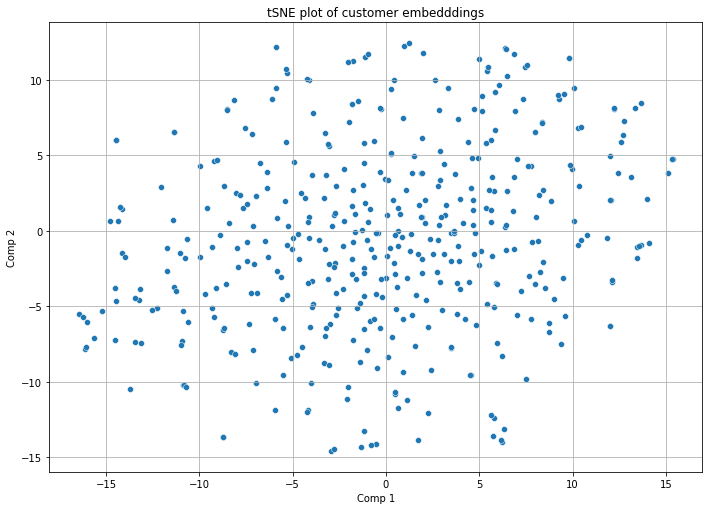

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib  import cm
from sklearn.manifold import TSNE
import seaborn as sns
fig = plt.figure(figsize=(11.7,8.27))
plt.grid(True)
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("tSNE plot of customer embedddings")
cust_embedded = TSNE(n_components=2).fit_transform(list(customer_emb.values()))
sns.scatterplot(cust_embedded[:,0], cust_embedded[:,1])

## Load the Item Projected Graph

In [16]:
fp = "data/item_projected_graph.csv"
df = pd.read_csv(fp)

In [17]:
ipg = nx.from_pandas_edgelist(df)

In [18]:
ipg.number_of_nodes()

75

## Generate the Embedding for the Item Projection Graph with Node2Vec

In [19]:
node2vec = Node2Vec(ipg, dimensions=32, walk_length=10, num_walks=100, workers=4)

In [20]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [21]:
item_embedding = { n: list(model.wv.get_vector(n)) for n in ipg.nodes()}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


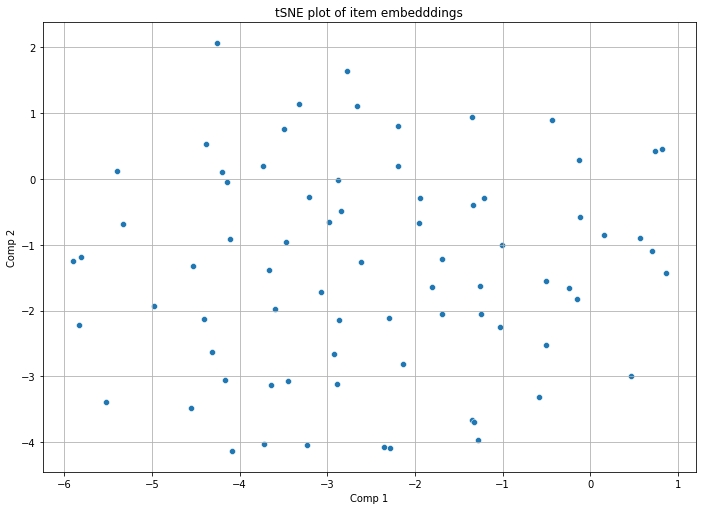

In [22]:
fig = plt.figure(figsize=(11.7,8.27))
plt.grid(True)
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("tSNE plot of item embedddings")
item_embedded = TSNE(n_components=2).fit_transform(list(item_embedding.values()))
sns.scatterplot(item_embedded[:,0], item_embedded[:,1])

## Plot the Customer Adjacency Matrix

In [23]:
# http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html

In [24]:
from matplotlib import pyplot, patches

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(11.7,8.27)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)

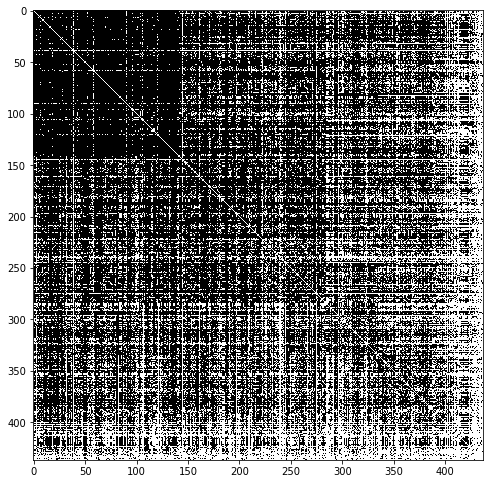

In [25]:

draw_adjacency_matrix(cpg)

## Plot the Item Adjacency Matrix

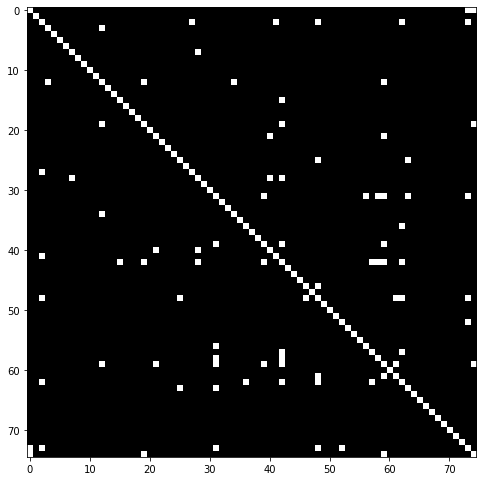

In [26]:
draw_adjacency_matrix(ipg)

## Cluster with HDB Scan - Investigate Clustering Tendency

In [27]:
! pip install hdbscan

     |████████████████████████████████| 6.4MB 5.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311672 sha256=eca73054870bdca28dc5a8b0ea74e8c20d1aedb8073dce2ce63971f7a5025495
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan


In [28]:
cna = np.zeros((cpg.number_of_nodes(), 32))
index = 0
for k,v in customer_emb.items():
  cna[index,:] = v
  index += 1

In [29]:
ina = np.zeros((ipg.number_of_nodes(), 32))
index = 0
for k,v in item_embedding.items():
  ina[index,:] = v
  index += 1

In [30]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_samples=5)
clusterer.fit(cna)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=5, p=None,
        prediction_data=False)

In [31]:
np.unique(clusterer.labels_)

array([-1])

## Verify Lack of Clustering with Hopkins Test

In [32]:
! pip install pyclustertend



In [33]:
from pyclustertend import hopkins
hopkins(cna,cpg.number_of_nodes())

0.3196735718444819

In [34]:
hopkins(cna,ipg.number_of_nodes())

0.3254924955385117

## Identify Outliers with Isolation Forest

In [35]:
fp = "data/feature_selected_freq_shoppers.csv"
df = pd.read_csv(fp)
colsraw = df.columns.tolist()
cols_to_keep = [c for c in colsraw if c not in ['Customer_ID', 'RFM_score']]
df = df[cols_to_keep]

In [36]:
from sklearn.ensemble import IsolationForest

In [37]:
X = df.values

In [38]:
clf =IsolationForest(random_state=0, contamination=0.1).fit(X)


In [39]:
clf.predict(X)

array([ 1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1, -1

## Log the Modeling Activity in Arangopipe

In [40]:
# ds_info = {"name" : "Frequent_Customer_Graph",\
#             "description": "Frequent Customer Graph of Retail Dataset",\
#            "source": "ArangoDB dump of Retail from Notebook II" }
# ds_reg = ap.register_dataset(ds_info)

In [41]:

# featureset = {"name": "Features are attributes of the nodes"}
# fs_reg = ap.register_featureset(featureset, ds_reg["_key"]) 

In [42]:
# import io
# import requests
# url = ('https://raw.githubusercontent.com/rajivsam/interactive_tutorials/master/notebooks/Graph_Retail_Descriptive_Analytics.ipynb')
# nbjson = requests.get(url).text

In [43]:

# model_info = {"name": "Descriptive Analytics for Frequent Customers",  "task": "Exploratory Data Analysis", 'notebook': nbjson}
# model_reg = ap.register_model(model_info, project = "Retail_Graph_Analytics")

In [44]:
# import uuid
# import datetime
# #import jsonpickle

# ruuid = str(uuid.uuid4().int)
# model_perf = {'run_id': ruuid, "timestamp": str(datetime.datetime.now())}

# #mp = jsonpickle.encode(mp)
# model_params = {'run_id': ruuid, 'model_params': 'Not Applicable'}

# run_info = {"dataset" : ds_reg["_key"],\
#                     "featureset": fs_reg["_key"],\
#                     "run_id": ruuid,\
#                     "model": model_reg["_key"],\
#                     "model-params": model_params,\
#                     "model-perf": model_perf,\
#                     "tag": "Retail Descriptive Analytics Notebook",\
#                     "project": "Retail_Graph_Analytics"}
# ap.log_run(run_info)